# Weather Recognition Model 
I will use a convolutional neural network to predict the weather in a provided image. As this is my first independent Machine Learning project, I will classify images into the classes: rain, lightning, and snow.

The data used was downloaded from https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

## 1 Data Preparation

I have downloaded and extracted the data from Kaggle, which is stored in the 'data' folder. Samples for each class are stored in corresponding folders inside - for example, all examples of rainy weather are stored in the 'data/rain' folder. I have removed all irrelevent class folders manually.

### 1.1 Dividing data into training, validation, and testing sets

I will divide the data into training, validation, and testing sets. 80% of the data will be used for testing and 10% used for both validation and testing.

In [72]:
import os

# Extract a list of file names for each class
rain_files = os.listdir('data/rain')
lightning_files = os.listdir('data/lightning')
snow_files = os.listdir('data/snow')

# Output how many files we have for each class
print(f"Number of rain samples: {len(rain_files)}")
print(f"Number of lightning samples: {len(lightning_files)}")
print(f"Number of snow samples: {len(snow_files)}")

Number of rain samples: 152
Number of lightning samples: 3
Number of snow samples: 247


There are an unequal amount of files in each class. Splitting the data now and training the model might cause the model to become biased to snow, the majority class. I have decided to use the undersampling technique; I will take 377 images from each class. I have made this decision because I believe this is a sufficient amount of data to adequately train and test the model.

In [73]:
import math

# Number of samples in smallest class
n = 377

# Work out sizes of each set
training_set_size = math.floor(n*0.8)
validation_set_size = math.floor(n*0.1)
testing_set_size = validation_set_size

# Add remaining samples to training set size
training_set_size += n - (training_set_size + validation_set_size + testing_set_size)

# Output size of each set
print("Training set size:", training_set_size)
print("Validation set size:", validation_set_size)
print("Testing set size:", testing_set_size)

Training set size: 303
Validation set size: 37
Testing set size: 37


To store the different datasets I will create 3 subfolders inside the rain, lightning, and snow folders: train, validate, and test. I will then choose the appropriate amount of random images and add them to the corresponding folder.

In [74]:
import shutil
from sklearn.utils import shuffle

os.chdir('data')

# Check if subfolders have already been created in case of a re-run
if os.path.isdir('rain/train') is False:
    # Create subfolders for training, validation, and testing
    os.makedirs('rain/train')
    os.makedirs('rain/validate')
    os.makedirs('rain/test')
    os.makedirs('lightning/train')
    os.makedirs('lightning/validate')
    os.makedirs('lightning/test')
    os.makedirs('snow/train')
    os.makedirs('snow/validate')
    os.makedirs('snow/test')
    
    # Shuffle list of file names, in case there is any order
    rain_files = shuffle(rain_files)
    lightning_files = shuffle(lightning_files)
    snow_files = shuffle(snow_files)
    
    # Populate folders
    for i in range(0, training_set_size):
        shutil.move(f'rain/{rain_files[i]}', 'rain/train')
        shutil.move(f'lightning/{lightning_files[i]}', 'lightning/train')
        shutil.move(f'snow/{snow_files[i]}', 'snow/train')
    for i in range(i + 1, i + validation_set_size + 1): # Continue using i from where we left off in previous for loop
        shutil.move(f'rain/{rain_files[i]}', 'rain/validate')
        shutil.move(f'lightning/{lightning_files[i]}', 'lightning/validate')
        shutil.move(f'snow/{snow_files[i]}', 'snow/validate')
    for i in range(i + 1, i + testing_set_size + 1):
        shutil.move(f'rain/{rain_files[i]}', 'rain/test')
        shutil.move(f'lightning/{lightning_files[i]}', 'lightning/test')
        shutil.move(f'snow/{snow_files[i]}', 'snow/test')
        
os.chdir('../')

In [75]:
# Ensure the correct number of files are in each folder
assert len(os.listdir('data/rain/train')) == len(os.listdir('data/lightning/train')) == len(os.listdir('data/snow/train')) == training_set_size
assert len(os.listdir('data/rain/validate')) == len(os.listdir('data/lightning/validate')) == len(os.listdir('data/snow/validate')) == validation_set_size
assert len(os.listdir('data/rain/test')) == len(os.listdir('data/lightning/test')) == len(os.listdir('data/snow/test')) == testing_set_size

### 1.2 Image normalisation

I will be using a Keras Sequential model to classify the images. Inspired by successful existing CNN models, decided to resize all images to 224x224. I will then use the the Keras image module to convert the image to an array. To reduce training time and ensure the red, green, and blue channels are in the same range, I will normalise the images by applying Min-Max scaling to the RGB channels with the range \[0,1\]. 

Initially, I also included image augmentation in this step to generate an additional image for each training example, but I found it didn't help very much with the generalisation of my model and slowed down training significantly, so I decided to remove it.

Here is the method I defined to normalise the images:

In [76]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import MinMaxScaler

# Define Min-Max scaler for RGB channel normalisation
scaler = MinMaxScaler(feature_range=(0, 1))

def normalise_image(file_path):
    # Load image and resize it to 224x224
    img = image.load_img(file_path, target_size=(224, 224))
    # Convert the image to a numpy array with shape (128, 128, 3)
    img = image.img_to_array(img)
    # The scaler expects a 2D array where each row corresponds to a sample and each column to a feature
    # Reshape image to (16384, 3) so the features can be scaled
    img = img.reshape(-1, 3)
    img = scaler.fit_transform(img)
    # Reshape image back to original dimensions
    return img.reshape(224, 224, 3)

### 1.4 Build training, validation, and testing sets

To build the training, validation, and testing sets I am iterating through all images in their respective folders, normalising them using the method defined in section 1.2, and saving them to their respective lists. I then build the lists of labels and convert them to numpy arrays.

In [77]:
classes = ['rain', 'lightning', 'snow']

training_data = []
validation_data = []
testing_data = []

# Iterate through different classes
for class_name in classes:
    # Append training images
    for file_name in os.listdir(f'data/{class_name}/train'):
        training_data.append(normalise_image(f'data/{class_name}/train/{file_name}'))
    # Append validation images
    for file_name in os.listdir(f'data/{class_name}/validate'):
        validation_data.append(normalise_image(f'data/{class_name}/validate/{file_name}'))
    # Append testing images
    for file_name in os.listdir(f'data/{class_name}/test'):
        testing_data.append(normalise_image(f'data/{class_name}/test/{file_name}'))
        
# Convert to numpy arrays so they can be used in a Sequential model
training_data = np.array(training_data)
validation_data = np.array(validation_data)
testing_data = np.array(testing_data)

As the data is added to the sets in order, we can build the labels relatively easily. I decided to build them as a list where 0 corresponds to rain, 1 to lightning, and 2 to snow. I then used the Keras to_categorical method to one-hot encode the labels so they are ready to be used in the model.

In [78]:
from tensorflow.keras.utils import to_categorical

# Build lists of labels
training_label = np.array([[i] for i in range(3) for j in range(training_set_size)])
validation_label = np.array([[i] for i in range(3) for j in range(validation_set_size)])
testing_label = np.array([[i] for i in range(3) for j in range(testing_set_size)])

# Ensure labels are one-hot encoded
# (1 0 0) corresponds to rain, (0 1 0) lightning, (0 0 1) snow
training_label = to_categorical(training_label, 3)
validation_label = to_categorical(validation_label, 3)
testing_label = to_categorical(testing_label, 3)

To ensure I haven't made any mistakes with dimensionality on the way, I will now use 'assert' to check the amount of samples in the training data matches the amount of training labels and the expected set size we calculated earlier.

In [79]:
assert training_data.shape[0] == training_label.shape[0] == training_set_size*3
assert validation_data.shape[0] == validation_label.shape[0] == validation_set_size*3
assert testing_data.shape[0] == testing_label.shape[0] == testing_set_size*3

Next I shuffle the training and validation data with their corresponding labels consistently.

In [80]:
training_data, training_label = shuffle(training_data, training_label)
validation_data, validation_label = shuffle(validation_data, validation_label)

## 2 Building the model

To build the model, I was inspired to use several sets of convolutional and max pooling layers by the structure of other well-known high performance models, such as VGG16. The filter size initially starts small and increases, making the feature space deeper, while the pooling layer decreases the first two dimensions of the feature space. The intuition behind this is captuing as much local information as possible at the beginning many using different kernels and and reducing the first two dimensions to extract and represent more high-level information.

Finally, the model is flattened and fed into a dense layer which gives our output.

I experimented with the impact of number of convolutional and pooling layers on the model and settled on 3 of each. Because I observed the model was overfitting the training set and not performing so well on the validation set, I decided to add a dropout before feeding the data into the dense layer. This means the model ignores randomly selected neurons during training, which can help increase generalisation.

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

# Define Sequential CNN model
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dropout(0.2),
    Dense(units=3, activation='softmax')
])

I used the Adam optimiser and a learning rate of 0.0001 as is common practice in similar CNN models. I decided to use categorical_crossentropy for the loss as it is designed specifically for classification problems.

In [82]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 256)      0

In [84]:
# Check the GPU has been detected and will be used for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


I now fit the model to the training data. After some experimentation, I decided to use 10 epochs and a batch size of 32.

In [85]:
model.fit(x=training_data,
          y=training_label,
         validation_data=(validation_data, validation_label),
         epochs=10,
         verbose=2,
         batch_size=32)

Epoch 1/10
29/29 - 38s - loss: 0.8979 - accuracy: 0.5204 - val_loss: 0.6859 - val_accuracy: 0.6757 - 38s/epoch - 1s/step
Epoch 2/10
29/29 - 27s - loss: 0.5998 - accuracy: 0.7173 - val_loss: 0.5315 - val_accuracy: 0.7568 - 27s/epoch - 929ms/step
Epoch 3/10
29/29 - 27s - loss: 0.4929 - accuracy: 0.7866 - val_loss: 0.4482 - val_accuracy: 0.8018 - 27s/epoch - 924ms/step
Epoch 4/10
29/29 - 26s - loss: 0.4013 - accuracy: 0.8559 - val_loss: 0.4291 - val_accuracy: 0.8198 - 26s/epoch - 903ms/step
Epoch 5/10
29/29 - 26s - loss: 0.3411 - accuracy: 0.8735 - val_loss: 0.3692 - val_accuracy: 0.8108 - 26s/epoch - 902ms/step
Epoch 6/10
29/29 - 26s - loss: 0.3064 - accuracy: 0.8966 - val_loss: 0.3481 - val_accuracy: 0.8378 - 26s/epoch - 902ms/step
Epoch 7/10
29/29 - 26s - loss: 0.2543 - accuracy: 0.9098 - val_loss: 0.2771 - val_accuracy: 0.8649 - 26s/epoch - 903ms/step
Epoch 8/10
29/29 - 29s - loss: 0.2477 - accuracy: 0.9065 - val_loss: 0.2922 - val_accuracy: 0.8739 - 29s/epoch - 992ms/step
Epoch 9/10


## 3 Testing the model
To test the model, I first generated a list of predictions from the testing set defined earlier.

In [86]:
# Predict image class for each image in testing data
print(testing_data.shape)
predictions = model.predict(x=testing_data)

# Pick the prediction with the highest confidence using argmax
predictions = np.argmax(predictions, axis=1)

(111, 224, 224, 3)
4/4 [==============================] - 1s 392ms/step


### 3.1 Generate confusion matrix

To interpret the results, I decided to create a confusion matrix using sklearn.

In [87]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=np.argmax(testing_label, axis=1),
                     y_pred=predictions)

To visualise the confusion matrix, I used matplotlib.

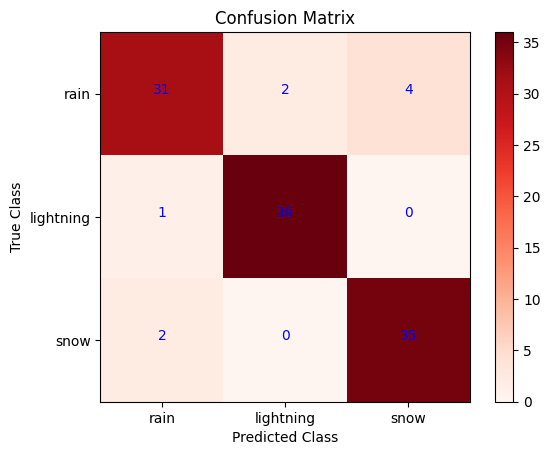

In [88]:
import matplotlib.pyplot as plt

plt.imshow(cm, cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()
# Tick marks should ve evenly spaced within the interval of 0-2
tick_marks = np.arange(start=0,
                      stop=3)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
# Display number of classified images for each component of the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="blue")

As can be seen in the confusion matrix, the model is very good at classifying the lightning and snow images, with only one of the test images misclassified for each set. However, the model hasn't captured the rain images as well. This might be because the dataset I used had a variety of images (in many of which it isn't actually raining) ranging from people walking in the rain to flooded streets.

Overall, I am pleased with the performance of this model. It had an accuracy of about 92% on the test set, which suggests it has captured general patterns seen in the images well.